In [129]:
!pip install category_encoders

The task is to find a suitable ML model for a processed table with information about auto loans in India, train the model and populate the target columns of the table from the test.csv table.

In [130]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import random
import category_encoders as ce
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedGroupKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score

random.seed(2024)

In [131]:

data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')


Let's retrieve the information about columns to interpret and undertstand them right. However, we will run into a problem: some descriptions are very long and do not fit in the cells. So we just open csv file using csv module for Python:



In [132]:
with open('data_dictionary.csv', 'r') as file:
  cols = csv.reader(file)
  next(cols)
  for num, (_, var_name, desc, __) in enumerate(cols):
    print(f'{num}. {var_name}: {desc}')

0. UniqueID: Identifier for customers
1. loan_default: Payment default in the first EMI on due date
2. disbursed_amount: Amount of Loan disbursed
3. asset_cost: Cost of the Asset
4. ltv: Loan to Value of the asset
5. branch_id: Branch where the loan was disbursed
6. supplier_id: Vehicle Dealer where the loan was disbursed
7. manufacturer_id: Vehicle manufacturer(Hero, Honda, TVS etc.)
8. Current_pincode: Current pincode of the customer
9. Date.of.Birth: Date of birth of the customer
10. Employment.Type: Employment Type of the customer (Salaried/Self Employed)
11. DisbursalDate: Date of disbursement
12. State_ID: State of disbursement
13. Employee_code_ID: Employee of the organization who logged the disbursement
14. MobileNo_Avl_Flag: if Mobile no. was shared by the customer then flagged as 1
15. Aadhar_flag: if aadhar was shared by the customer then flagged as 1
16. PAN_flag: if pan was shared by the customer then flagged as 1
17. VoterID_flag: if voter  was shared by the customer then

Uh, there are a lot of different specific columns. It's nessasary to realize sence of each column for following data analasys. We can definetely notice that columns from 0 to 19 refer to the act of buying itself, after that there are some features of customer's credit history. The column "SEC.NO.OF.ACCTS" differs from the "PRI.NO.OF.ACCTS" column in that the former involves counting the total number of credits of a person who is close to the customer.



In [133]:
data_train.nunique()

UniqueID                               233154
disbursed_amount                        24565
asset_cost                              46252
ltv                                      6579
branch_id                                  82
supplier_id                              2953
manufacturer_id                            11
Current_pincode_ID                       6698
Date.of.Birth                           15433
Employment.Type                             2
DisbursalDate                              84
State_ID                                   22
Employee_code_ID                         3270
MobileNo_Avl_Flag                           1
Aadhar_flag                                 2
PAN_flag                                    2
VoterID_flag                                2
Driving_flag                                2
Passport_flag                               2
PERFORM_CNS.SCORE                         573
PERFORM_CNS.SCORE.DESCRIPTION              20
PRI.NO.OF.ACCTS                   

In [134]:
data_train.isnull().sum()

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

In [135]:
data_train.isna().sum()

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

# Numerical columns

Let's consider numerical columns. This is important to note that some categorical data is present. Some of them will be considered unnecessary. I will remove the UniqueID and MobileNo_Avl_Flag columns for reasons that become clear after considering the unique values of the columns.




In [138]:
num_cols = data_train.select_dtypes(exclude='object')
num_cols.drop(['UniqueID', 'MobileNo_Avl_Flag'] , inplace=True, axis=1)
num_cols.shape

(233154, 33)

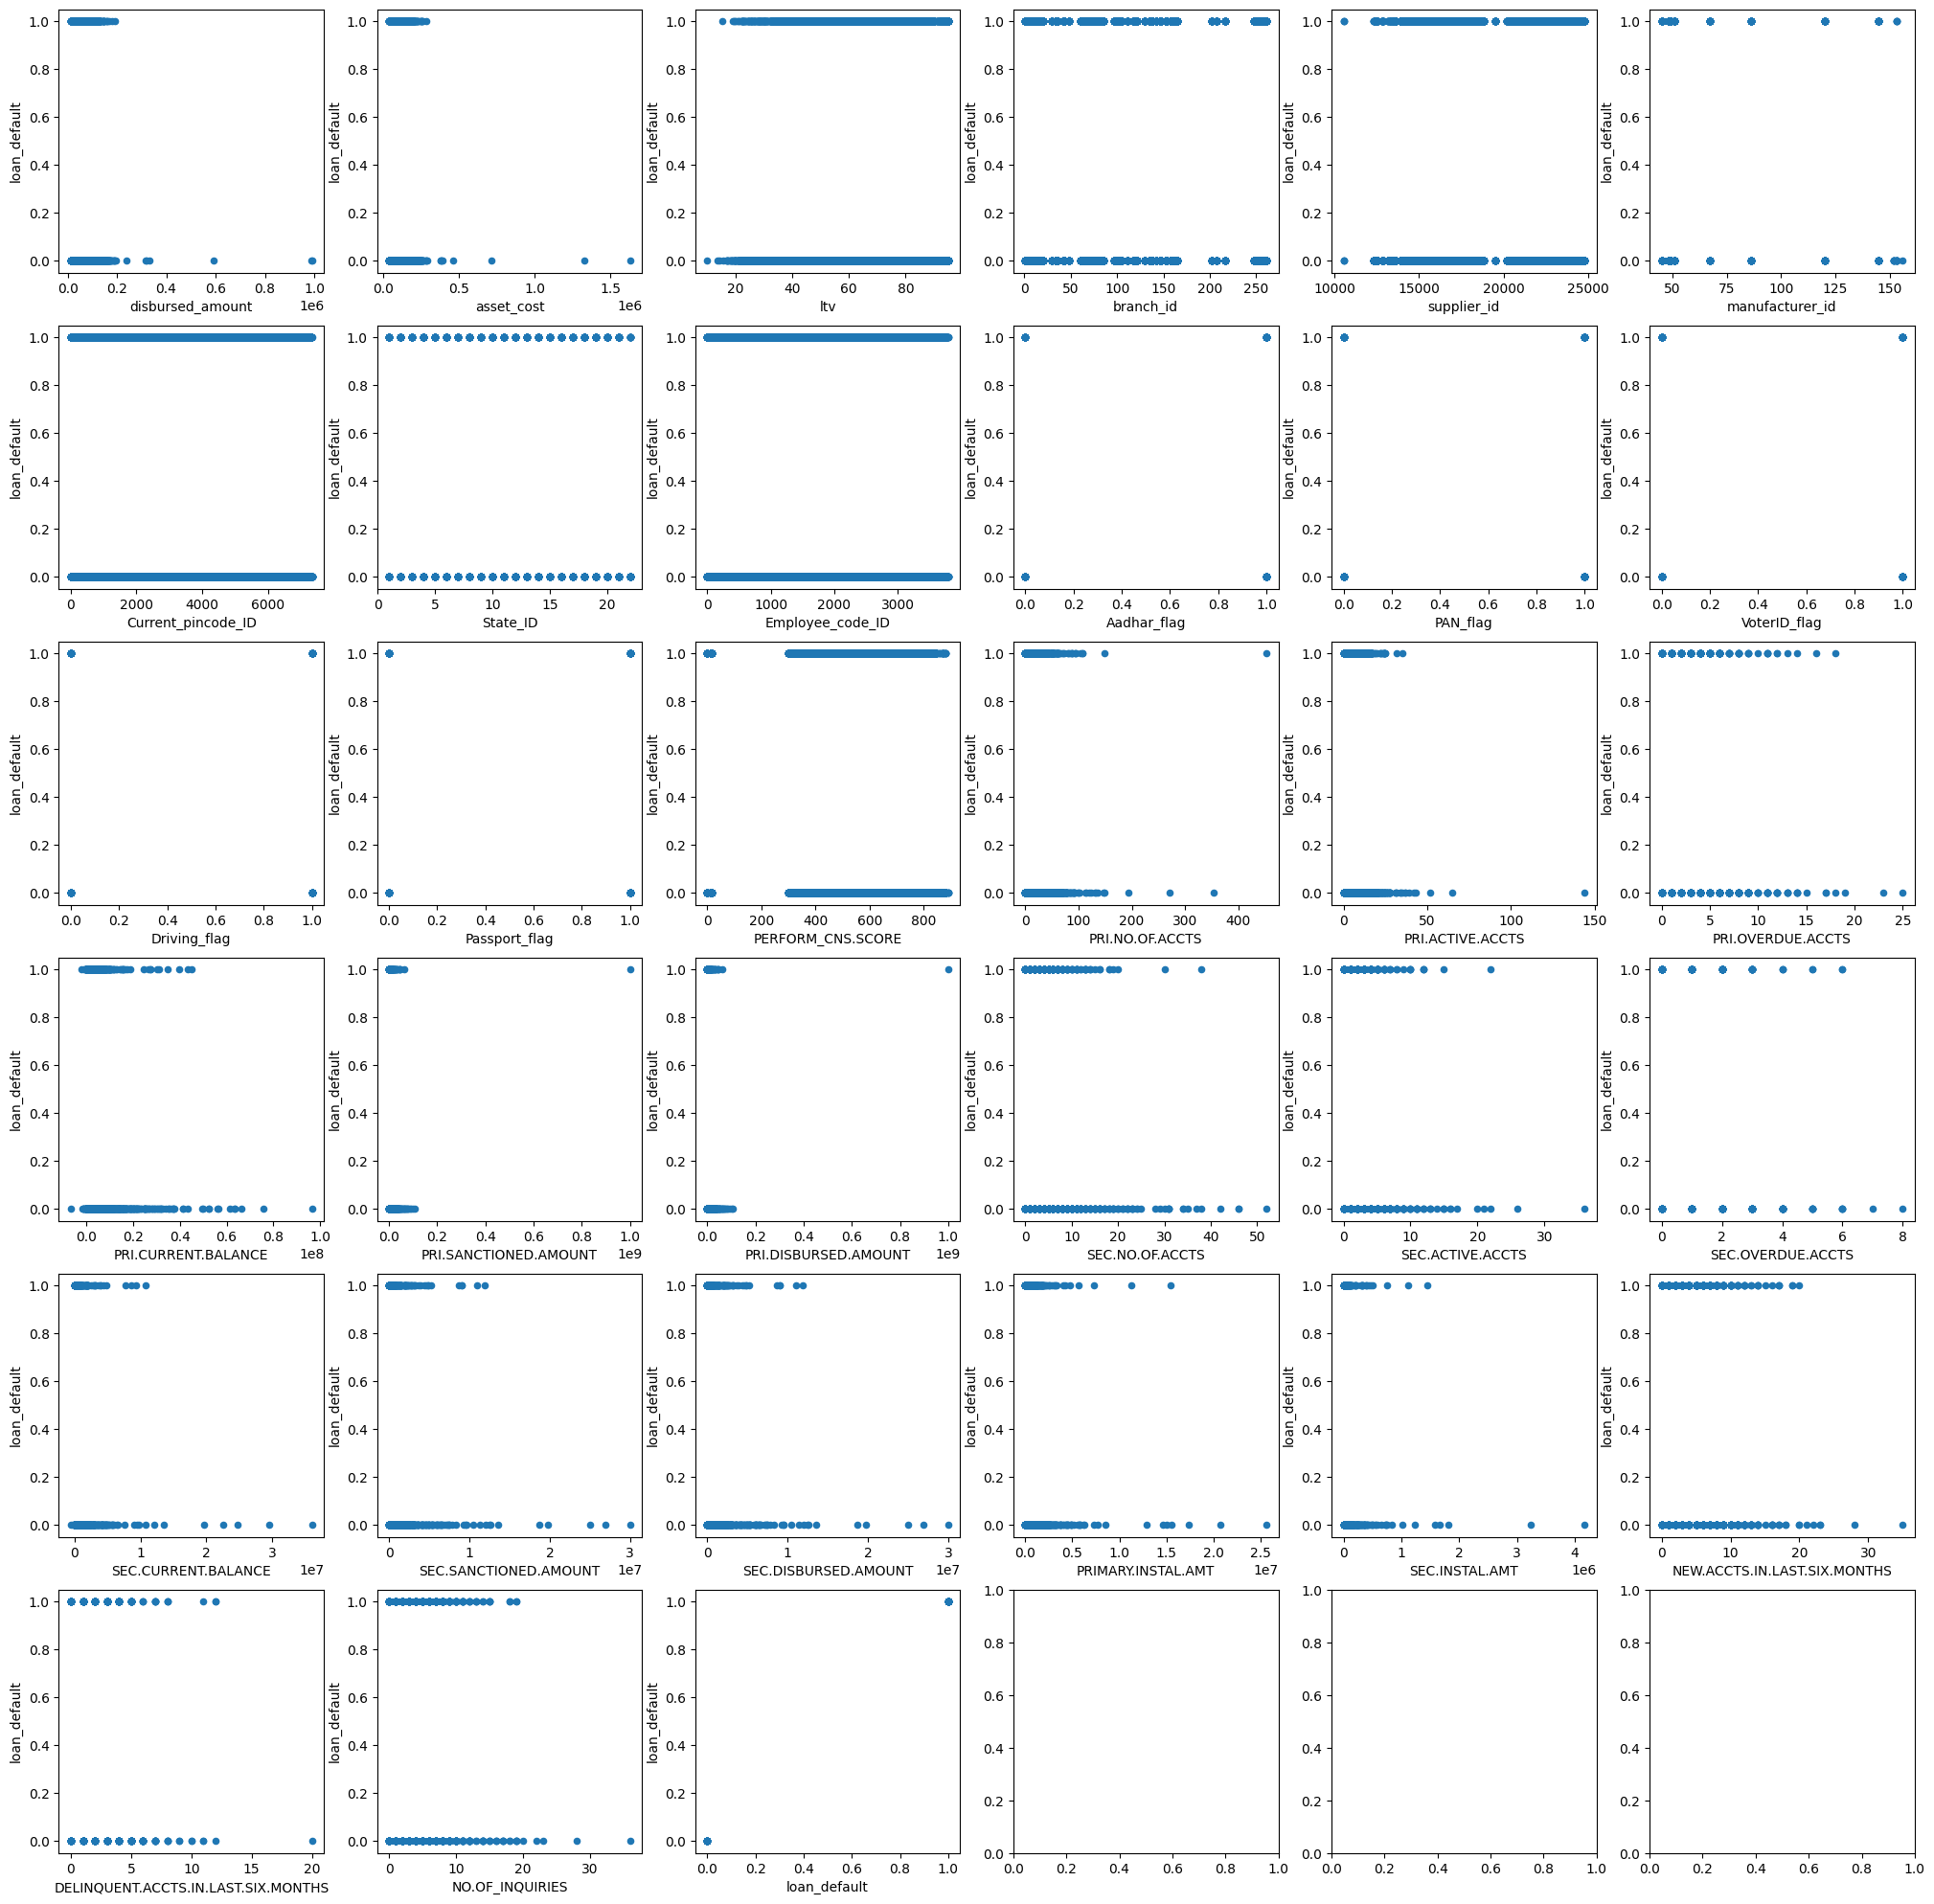

In [139]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(25,25))
for idx, feature in enumerate(num_cols.columns):
  num_cols.plot(feature, 'loan_default', subplots=True, kind='scatter', ax = axes[idx // 6, idx % 6])

That's difficult to say something certain about these dependings, at first glance. Hovewer, finaly, we have realazed that we need to consider dicrete and continious variables separately. In addition, we can already see some features that won't unlikely be useful for following considering: branch_id, supplier_id, current_pincode, state_id, employee_code_id.

Let's look at other plots of these features to be sure of that exactly.

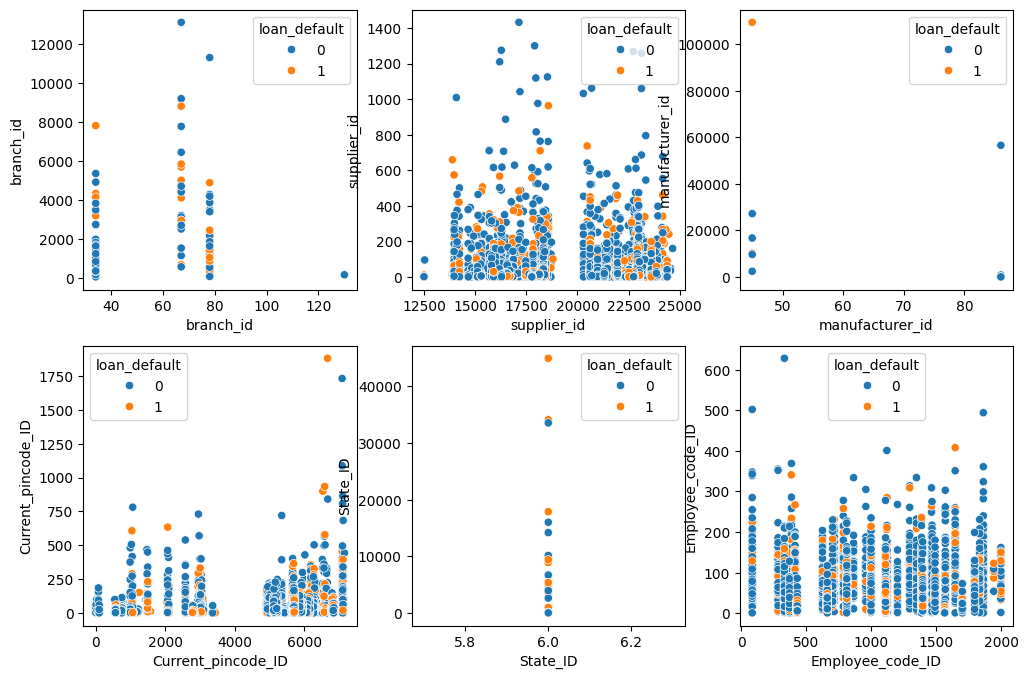

In [140]:
lst = ['branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'State_ID', 'Employee_code_ID']
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i in range(len(lst)):
  sns.scatterplot(data=data_train, x=data_train[lst[i]], y=data_train[lst[i]].value_counts(), hue=data_train['loan_default'], ax = axes[int(i>2), i-int(i>2)*3])



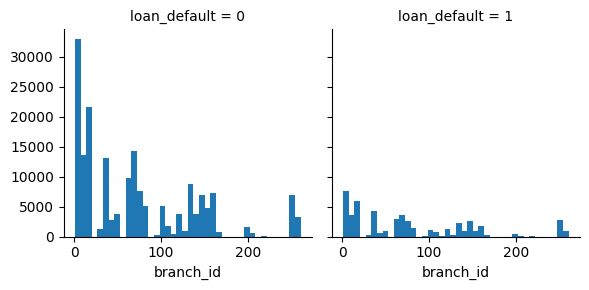

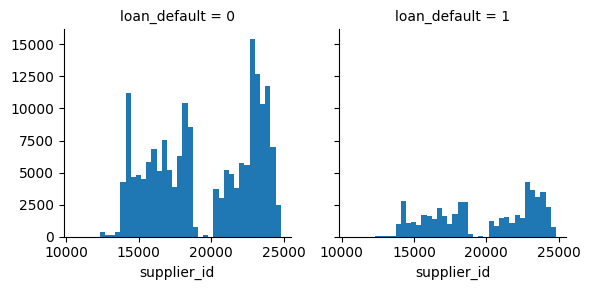

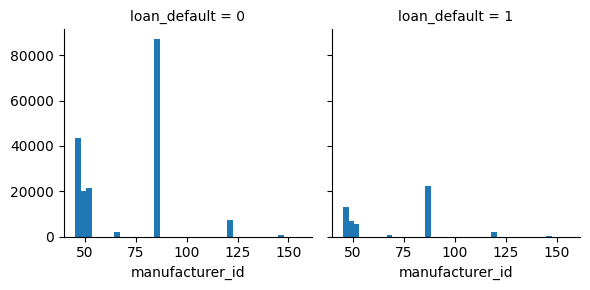

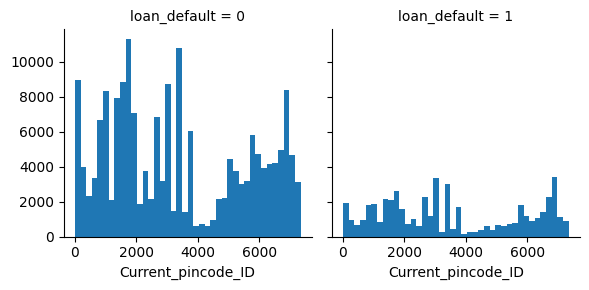

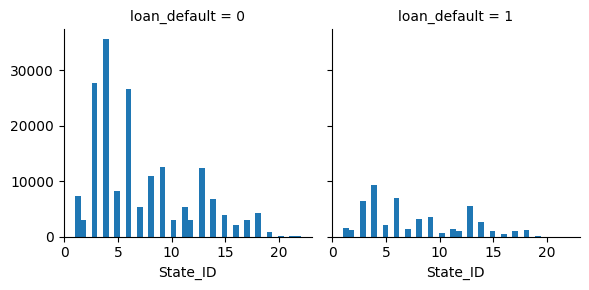

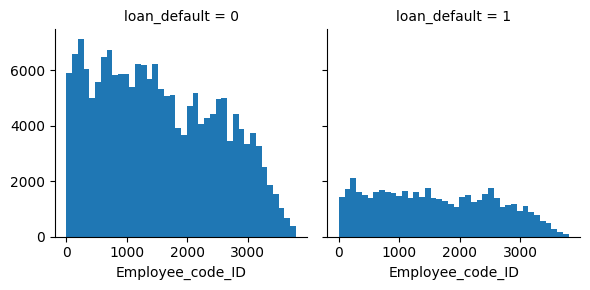

In [141]:
for name in lst:
  g = sns.FacetGrid(data_train, col='loan_default')
  g.map(plt.hist, name, bins=40)

We can see that behavior of the number of people for clause loan_default = 0 and behavior of the number for clause = 1 are similar. Only difference is the number for each value of x axis (for each employee, for each current_pincode_ID etc.). Thus, I don't think they will be useful information for follow up, we can discard them without leaking important information. However, let's check correltaion between them and loan_default.

<ipython-input-142-c8c4ee95ec87>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_default'] = data_train['loan_default']


<Axes: >

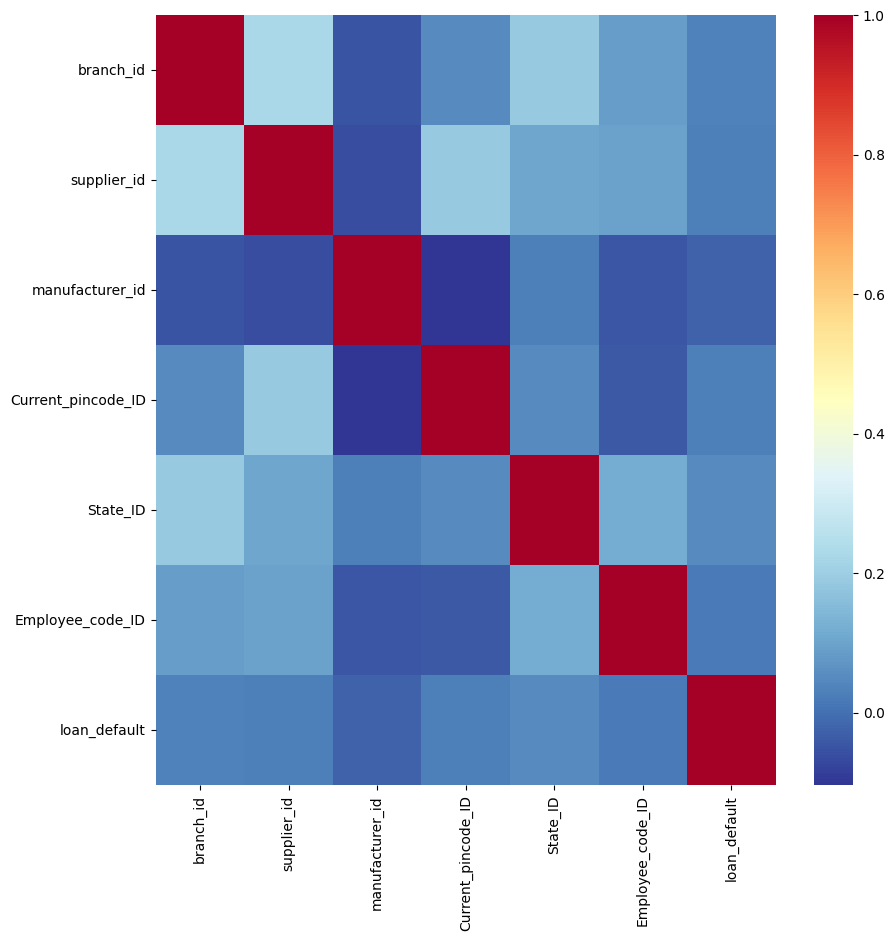

In [142]:
df = data_train[lst]
df['loan_default'] = data_train['loan_default']

plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap="RdYlBu_r")

I removed StateID from the lst list because we see little correlation between this column and the loan_default columns in the heatmap. However, we need to change this column because firstly, this is categorical data and loan_default may depend on the Indian region where the loan was taken.

In [143]:
lst.remove('State_ID')
num_cols.drop(lst, inplace=True, axis=1)
num_cols

,disbursed_amount,asset_cost,ltv,State_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,...,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,47145,65550,73.23,6,1,0,0,0,0,598,...,0,0,0,0,1991,0,0,1,0,1
2,53278,61360,89.63,6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,57513,66113,88.48,6,1,0,0,0,0,305,...,0,0,0,0,31,0,0,0,1,1
4,52378,60300,88.39,6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,63213,105405,60.72,6,0,0,1,0,0,735,...,0,0,0,0,4084,0,0,0,0,0
233150,73651,100600,74.95,6,0,0,1,0,0,825,...,0,0,0,0,1565,0,0,0,0,0
233151,33484,71212,48.45,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233152,34259,73286,49.10,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's continue simplifying the table. Next, this can be accomplished by merging similar columns. Exactly, we won't lose any piece of data merging columns "PRI.NO.OF.ACCTS" and "SEC.NO.OF.ACCTS", because they imply same feature for two people, Thus, we should merge these columns.

In [144]:
lst = list(num_cols.columns)
for col in num_cols.columns[lst.index('PRI.NO.OF.ACCTS'):lst.index('SEC.NO.OF.ACCTS')]:
  num_cols[f'{col.strip("PRI.").replace(".", "_").lower()}'] = num_cols[col] + num_cols[f'SEC.{col[4:]}']
  num_cols.drop([col, f'SEC.{col[4:]}'], inplace=True, axis=1)

num_cols['instal_amt'] = num_cols['PRIMARY.INSTAL.AMT'] + num_cols['SEC.INSTAL.AMT']
num_cols.drop(['PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT'], inplace=True, axis=1)

Moreover, we can see flags like Aadhar_flag, PAN_flag in the table. They mean that the client has submitted the right documents. It would be better to use only one column instead of all of them.

In [145]:
num_cols['flags'] = np.zeros(num_cols['Aadhar_flag'].shape)
for col in num_cols.columns[lst.index('Aadhar_flag'): lst.index('PERFORM_CNS.SCORE')]:
  num_cols['flags'] = num_cols['flags'] + num_cols[col]
  num_cols.drop(col, inplace=True, axis=1)


In [146]:
def rename_col(string):
  new_string = string.lower().replace('.', '_')
  return new_string

to_rename = {name: rename_col(name) for name in ['PERFORM_CNS.SCORE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES']}

num_cols = num_cols.rename(columns=to_rename)

num_cols

,disbursed_amount,asset_cost,ltv,State_ID,perform_cns_score,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,no_of_inquiries,loan_default,no_of_accts,active_accts,overdue_accts,current_balance,sanctioned_amount,instal_amt,flags
0,0,58400,89.55,6,0,0,0,0,0,0,0,0,0,0,0,1.0
1,50200,65550,73.23,6,598,0,1,0,1,1,1,1,27600,50200,1991,1.0
2,0,61360,89.63,6,0,0,0,0,0,0,0,0,0,0,0,1.0
3,0,66113,88.48,6,305,0,0,1,1,3,0,0,0,0,31,1.0
4,0,60300,88.39,6,0,0,0,1,1,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,416133,105405,60.72,6,735,0,0,0,0,4,3,0,390443,416133,4084,1.0
233150,0,100600,74.95,6,825,0,0,0,0,1,0,0,0,0,1565,1.0
233151,0,71212,48.45,4,0,0,0,0,0,0,0,0,0,0,0,1.0
233152,0,73286,49.10,4,0,0,0,0,0,0,0,0,0,0,0,1.0


If we use State_ID, there will be some problems because it has its own ordering, but we cannot interpret each number as a specific Indian region. Thus, we will assume that all regions are equal. We will use binary encondering to fix this.

In [147]:
enconder = ce.binary.BinaryEncoder()

new_col = enconder.fit_transform(num_cols['State_ID'])
num_cols.drop('State_ID', inplace=True, axis=1)
num_cols = pd.concat([num_cols, new_col], axis=1)
num_cols

,disbursed_amount,asset_cost,ltv,perform_cns_score,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,no_of_inquiries,loan_default,no_of_accts,active_accts,overdue_accts,current_balance,sanctioned_amount,instal_amt,flags,State_ID
0,0,58400,89.55,0,0,0,0,0,0,0,0,0,0,0,1.0,6
1,50200,65550,73.23,598,0,1,0,1,1,1,1,27600,50200,1991,1.0,6
2,0,61360,89.63,0,0,0,0,0,0,0,0,0,0,0,1.0,6
3,0,66113,88.48,305,0,0,1,1,3,0,0,0,0,31,1.0,6
4,0,60300,88.39,0,0,0,1,1,0,0,0,0,0,0,1.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,416133,105405,60.72,735,0,0,0,0,4,3,0,390443,416133,4084,1.0,6
233150,0,100600,74.95,825,0,0,0,0,1,0,0,0,0,1565,1.0,6
233151,0,71212,48.45,0,0,0,0,0,0,0,0,0,0,0,1.0,4
233152,0,73286,49.10,0,0,0,0,0,0,0,0,0,0,0,1.0,4


# Categorical columns

In [148]:
cat_cols = data_train.select_dtypes(include='object')
cat_cols

,Date.of.Birth,Employment.Type,DisbursalDate,PERFORM_CNS.SCORE.DESCRIPTION,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH
0,01-01-84,Salaried,03-08-18,No Bureau History Available,0yrs 0mon,0yrs 0mon
1,31-07-85,Self employed,26-09-18,I-Medium Risk,1yrs 11mon,1yrs 11mon
2,24-08-85,Self employed,01-08-18,No Bureau History Available,0yrs 0mon,0yrs 0mon
3,30-12-93,Self employed,26-10-18,L-Very High Risk,0yrs 8mon,1yrs 3mon
4,09-12-77,Self employed,26-09-18,No Bureau History Available,0yrs 0mon,0yrs 0mon
...,...,...,...,...,...,...
233149,01-08-88,Salaried,26-10-18,D-Very Low Risk,1yrs 9mon,3yrs 3mon
233150,05-12-88,Self employed,23-10-18,A-Very Low Risk,0yrs 6mon,0yrs 6mon
233151,01-06-76,Salaried,24-10-18,No Bureau History Available,0yrs 0mon,0yrs 0mon
233152,26-03-94,Salaried,29-09-18,No Bureau History Available,0yrs 0mon,0yrs 0mon


In [149]:

to_rename = {name: rename_col(name) for name in cat_cols.columns}

cat_cols = cat_cols.rename(columns=to_rename)
cat_cols

,date_of_birth,employment_type,disbursaldate,perform_cns_score_description,average_acct_age,credit_history_length
0,01-01-84,Salaried,03-08-18,No Bureau History Available,0yrs 0mon,0yrs 0mon
1,31-07-85,Self employed,26-09-18,I-Medium Risk,1yrs 11mon,1yrs 11mon
2,24-08-85,Self employed,01-08-18,No Bureau History Available,0yrs 0mon,0yrs 0mon
3,30-12-93,Self employed,26-10-18,L-Very High Risk,0yrs 8mon,1yrs 3mon
4,09-12-77,Self employed,26-09-18,No Bureau History Available,0yrs 0mon,0yrs 0mon
...,...,...,...,...,...,...
233149,01-08-88,Salaried,26-10-18,D-Very Low Risk,1yrs 9mon,3yrs 3mon
233150,05-12-88,Self employed,23-10-18,A-Very Low Risk,0yrs 6mon,0yrs 6mon
233151,01-06-76,Salaried,24-10-18,No Bureau History Available,0yrs 0mon,0yrs 0mon
233152,26-03-94,Salaried,29-09-18,No Bureau History Available,0yrs 0mon,0yrs 0mon


First, we can see some data that could be proccessed by datetime module Python. Except it, there are Employment.Type and PERFORM_CNS.SCORE.DESCRIPTION columns. First can be intrepretted as flags that were earlier. Second column can us help to better understand values from perform_cns_score. Let's start by considering it.

In [150]:
# cat_cols['perform_cns_score_description'] = cat_cols['perform_cns_score_description'].apply(lambda x: 0 if x is np.isnan else x)
# num_cols['perform_cns_score'] = num_cols['perform_cns_score'].apply(lambda x: 0 if x is np.isnan else x)

bins = cat_cols['perform_cns_score_description'].fillna('Null')
labels = num_cols['perform_cns_score'].fillna(0)

dct = {}
for bin in set(bins):
  if bin is not np.nan:
    dct.update({bin: [0, 10**6]})
  else:
    dct.update({'null': [0, 0]})
    bins.drop(np.nan, axis)
    bins.append('null')

for i in range(len(labels)):
  if dct[bins[i]] == [0, 10**6]:
    dct[bins[i]] = [labels[i], labels[i]]
  else:
    if dct[bins[i]][0] > labels[i]:
      dct[bins[i]][0] = labels[i]
    elif dct[bins[i]][1] < labels[i]:
      dct[bins[i]][1] = labels[i]
dct

{'Not Scored: Sufficient History Not Available': [15, 15],
 'M-Very High Risk': [300, 300],
 'L-Very High Risk': [301, 350],
 'Not Scored: No Activity seen on the customer (Inactive)': [16, 16],
 'G-Low Risk': [631, 650],
 'E-Low Risk': [681, 705],
 'F-Low Risk': [651, 680],
 'D-Very Low Risk': [706, 735],
 'Not Scored: Only a Guarantor': [14, 14],
 'Not Scored: Not Enough Info available on the customer': [17, 17],
 'B-Very Low Risk': [761, 805],
 'C-Very Low Risk': [736, 760],
 'Not Scored: No Updates available in last 36 months': [18, 18],
 'No Bureau History Available': [0, 0],
 'Not Scored: More than 50 active Accounts found': [11, 11],
 'K-High Risk': [351, 520],
 'A-Very Low Risk': [806, 890],
 'H-Medium Risk': [601, 630],
 'J-High Risk': [521, 570],
 'I-Medium Risk': [571, 600]}

So now we know the value of the bounds for each level of risk. However, there are some unspecified levels "Not scored". Assume, this would be the entry level. The order of the rest is quite clear.

In [151]:
dct['Entry'] = [0]
for key in dct.keys():
  if key[:2] == 'No':
    dct['Entry'].append(dct[key][0])

dct = {key: dct[key] for key in sorted(dct)}

for i in range(7):
  dct.popitem()

last_value = dct.pop('Entry')
dct.setdefault('Entry', last_value)
dct


{'A-Very Low Risk': [806, 890],
 'B-Very Low Risk': [761, 805],
 'C-Very Low Risk': [736, 760],
 'D-Very Low Risk': [706, 735],
 'E-Low Risk': [681, 705],
 'F-Low Risk': [651, 680],
 'G-Low Risk': [631, 650],
 'H-Medium Risk': [601, 630],
 'I-Medium Risk': [571, 600],
 'J-High Risk': [521, 570],
 'K-High Risk': [351, 520],
 'L-Very High Risk': [301, 350],
 'M-Very High Risk': [300, 300],
 'Entry': [0, 15, 16, 14, 17, 18, 0, 11]}

There less than 15 different groups, and they have their own order. This is reason to choose simple LabelEncoding! And we can do it manually!

In [152]:
new_keys = {val: num for num, val in enumerate(reversed(dct))}
keys_cns = {tuple(dct[val]): new_keys[val] for val in new_keys}

def new_score_cns(num):
  for borders in keys_cns:
    if  borders[0] <= num <= borders[1]:
      return keys_cns[borders]
  return 0

keys_cns

{(0, 15, 16, 14, 17, 18, 0, 11): 0,
 (300, 300): 1,
 (301, 350): 2,
 (351, 520): 3,
 (521, 570): 4,
 (571, 600): 5,
 (601, 630): 6,
 (631, 650): 7,
 (651, 680): 8,
 (681, 705): 9,
 (706, 735): 10,
 (736, 760): 11,
 (761, 805): 12,
 (806, 890): 13}

In [153]:
num_cols['perform_cns_score'] = num_cols['perform_cns_score'].apply(new_score_cns)
cat_cols.drop('perform_cns_score_description', inplace=True, axis=1)
num_cols['perform_cns_score']

0          0
1          5
2          0
3          2
4          0
          ..
233149    10
233150    13
233151     0
233152     0
233153     0
Name: perform_cns_score, Length: 233154, dtype: int64

It's important to process employment_type column before working with dates. It contains only two values: Salaried or Self employed. But let's check if there are NaN values

In [154]:
cat_cols['employment_type'].isna().sum()

7661

In [155]:


def change_empl_type(string):
  variants = {'Salaried': 1, 'Self employed': 0, 0: 0, 1: 1, np.nan: 0}
  return variants[string]

combine = pd.concat([num_cols, cat_cols], axis=1)

df = combine.copy()
df['employment_type'] = df['employment_type'].dropna().apply(change_empl_type)

df


,disbursed_amount,asset_cost,ltv,perform_cns_score,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,no_of_inquiries,loan_default,no_of_accts,active_accts,...,current_balance,sanctioned_amount,instal_amt,flags,State_ID,date_of_birth,employment_type,disbursaldate,average_acct_age,credit_history_length
0,0,58400,89.55,0,0,0,0,0,0,0,...,0,0,0,1.0,6,01-01-84,1.0,03-08-18,0yrs 0mon,0yrs 0mon
1,50200,65550,73.23,5,0,1,0,1,1,1,...,27600,50200,1991,1.0,6,31-07-85,0.0,26-09-18,1yrs 11mon,1yrs 11mon
2,0,61360,89.63,0,0,0,0,0,0,0,...,0,0,0,1.0,6,24-08-85,0.0,01-08-18,0yrs 0mon,0yrs 0mon
3,0,66113,88.48,2,0,0,1,1,3,0,...,0,0,31,1.0,6,30-12-93,0.0,26-10-18,0yrs 8mon,1yrs 3mon
4,0,60300,88.39,0,0,0,1,1,0,0,...,0,0,0,1.0,6,09-12-77,0.0,26-09-18,0yrs 0mon,0yrs 0mon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,416133,105405,60.72,10,0,0,0,0,4,3,...,390443,416133,4084,1.0,6,01-08-88,1.0,26-10-18,1yrs 9mon,3yrs 3mon
233150,0,100600,74.95,13,0,0,0,0,1,0,...,0,0,1565,1.0,6,05-12-88,0.0,23-10-18,0yrs 6mon,0yrs 6mon
233151,0,71212,48.45,0,0,0,0,0,0,0,...,0,0,0,1.0,4,01-06-76,1.0,24-10-18,0yrs 0mon,0yrs 0mon
233152,0,73286,49.10,0,0,0,0,0,0,0,...,0,0,0,1.0,4,26-03-94,1.0,29-09-18,0yrs 0mon,0yrs 0mon


That's a pity... It will be difficult to account for every dependency between the employment_type column and the others. Therefore, let's fill each NaN-value using random distribution.

(array([127635.,  97858.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

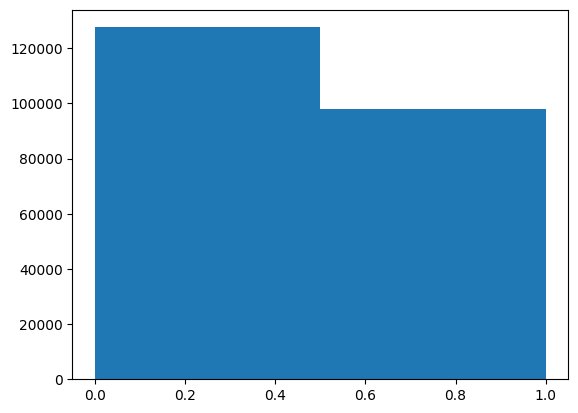

In [156]:
#Before filling

plt.hist(df['employment_type'], bins=2)


<ipython-input-157-e070e396e215>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  imputer.fit_transform(combine['employment_type'][:, np.newaxis])


(array([135296.,  97858.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

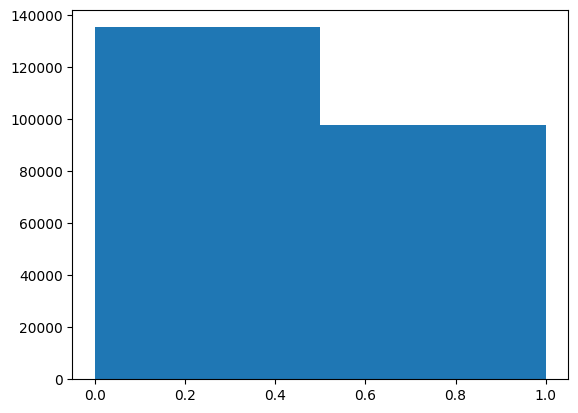

In [157]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")

combine['employment_type'] = combine['employment_type'].apply(change_empl_type)
imputer.fit_transform(combine['employment_type'][:, np.newaxis])


plt.hist(combine['employment_type'], bins=2)


So far, no obvious changes have been observed

Thus, dates from the table are the rest: date_of_birth, disbursaldate, average_acct_age, credit_history_length. The first column we can transform and keep just year of birth. I don't think that month and day are really important for analysis.

In [158]:
combine

,disbursed_amount,asset_cost,ltv,perform_cns_score,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,no_of_inquiries,loan_default,no_of_accts,active_accts,...,current_balance,sanctioned_amount,instal_amt,flags,State_ID,date_of_birth,employment_type,disbursaldate,average_acct_age,credit_history_length
0,0,58400,89.55,0,0,0,0,0,0,0,...,0,0,0,1.0,6,01-01-84,1,03-08-18,0yrs 0mon,0yrs 0mon
1,50200,65550,73.23,5,0,1,0,1,1,1,...,27600,50200,1991,1.0,6,31-07-85,0,26-09-18,1yrs 11mon,1yrs 11mon
2,0,61360,89.63,0,0,0,0,0,0,0,...,0,0,0,1.0,6,24-08-85,0,01-08-18,0yrs 0mon,0yrs 0mon
3,0,66113,88.48,2,0,0,1,1,3,0,...,0,0,31,1.0,6,30-12-93,0,26-10-18,0yrs 8mon,1yrs 3mon
4,0,60300,88.39,0,0,0,1,1,0,0,...,0,0,0,1.0,6,09-12-77,0,26-09-18,0yrs 0mon,0yrs 0mon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,416133,105405,60.72,10,0,0,0,0,4,3,...,390443,416133,4084,1.0,6,01-08-88,1,26-10-18,1yrs 9mon,3yrs 3mon
233150,0,100600,74.95,13,0,0,0,0,1,0,...,0,0,1565,1.0,6,05-12-88,0,23-10-18,0yrs 6mon,0yrs 6mon
233151,0,71212,48.45,0,0,0,0,0,0,0,...,0,0,0,1.0,4,01-06-76,1,24-10-18,0yrs 0mon,0yrs 0mon
233152,0,73286,49.10,0,0,0,0,0,0,0,...,0,0,0,1.0,4,26-03-94,1,29-09-18,0yrs 0mon,0yrs 0mon


In [159]:
def transform_birth(string):
  date = datetime.strptime(string, '%d-%m-%y')
  return date.year


combine['date_of_birth'] = combine['date_of_birth'].apply(transform_birth)
combine = combine.rename(columns={'date_of_birth': 'year_of_birth'})
combine

,disbursed_amount,asset_cost,ltv,perform_cns_score,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,no_of_inquiries,loan_default,no_of_accts,active_accts,...,current_balance,sanctioned_amount,instal_amt,flags,State_ID,year_of_birth,employment_type,disbursaldate,average_acct_age,credit_history_length
0,0,58400,89.55,0,0,0,0,0,0,0,...,0,0,0,1.0,6,1984,1,03-08-18,0yrs 0mon,0yrs 0mon
1,50200,65550,73.23,5,0,1,0,1,1,1,...,27600,50200,1991,1.0,6,1985,0,26-09-18,1yrs 11mon,1yrs 11mon
2,0,61360,89.63,0,0,0,0,0,0,0,...,0,0,0,1.0,6,1985,0,01-08-18,0yrs 0mon,0yrs 0mon
3,0,66113,88.48,2,0,0,1,1,3,0,...,0,0,31,1.0,6,1993,0,26-10-18,0yrs 8mon,1yrs 3mon
4,0,60300,88.39,0,0,0,1,1,0,0,...,0,0,0,1.0,6,1977,0,26-09-18,0yrs 0mon,0yrs 0mon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,416133,105405,60.72,10,0,0,0,0,4,3,...,390443,416133,4084,1.0,6,1988,1,26-10-18,1yrs 9mon,3yrs 3mon
233150,0,100600,74.95,13,0,0,0,0,1,0,...,0,0,1565,1.0,6,1988,0,23-10-18,0yrs 6mon,0yrs 6mon
233151,0,71212,48.45,0,0,0,0,0,0,0,...,0,0,0,1.0,4,1976,1,24-10-18,0yrs 0mon,0yrs 0mon
233152,0,73286,49.10,0,0,0,0,0,0,0,...,0,0,0,1.0,4,1994,1,29-09-18,0yrs 0mon,0yrs 0mon


We need to convert the disbursaldate column using the datetime module to see what we can do with the disbursaldate columns. After that, it would be interesting to look at the distributions and statistics.

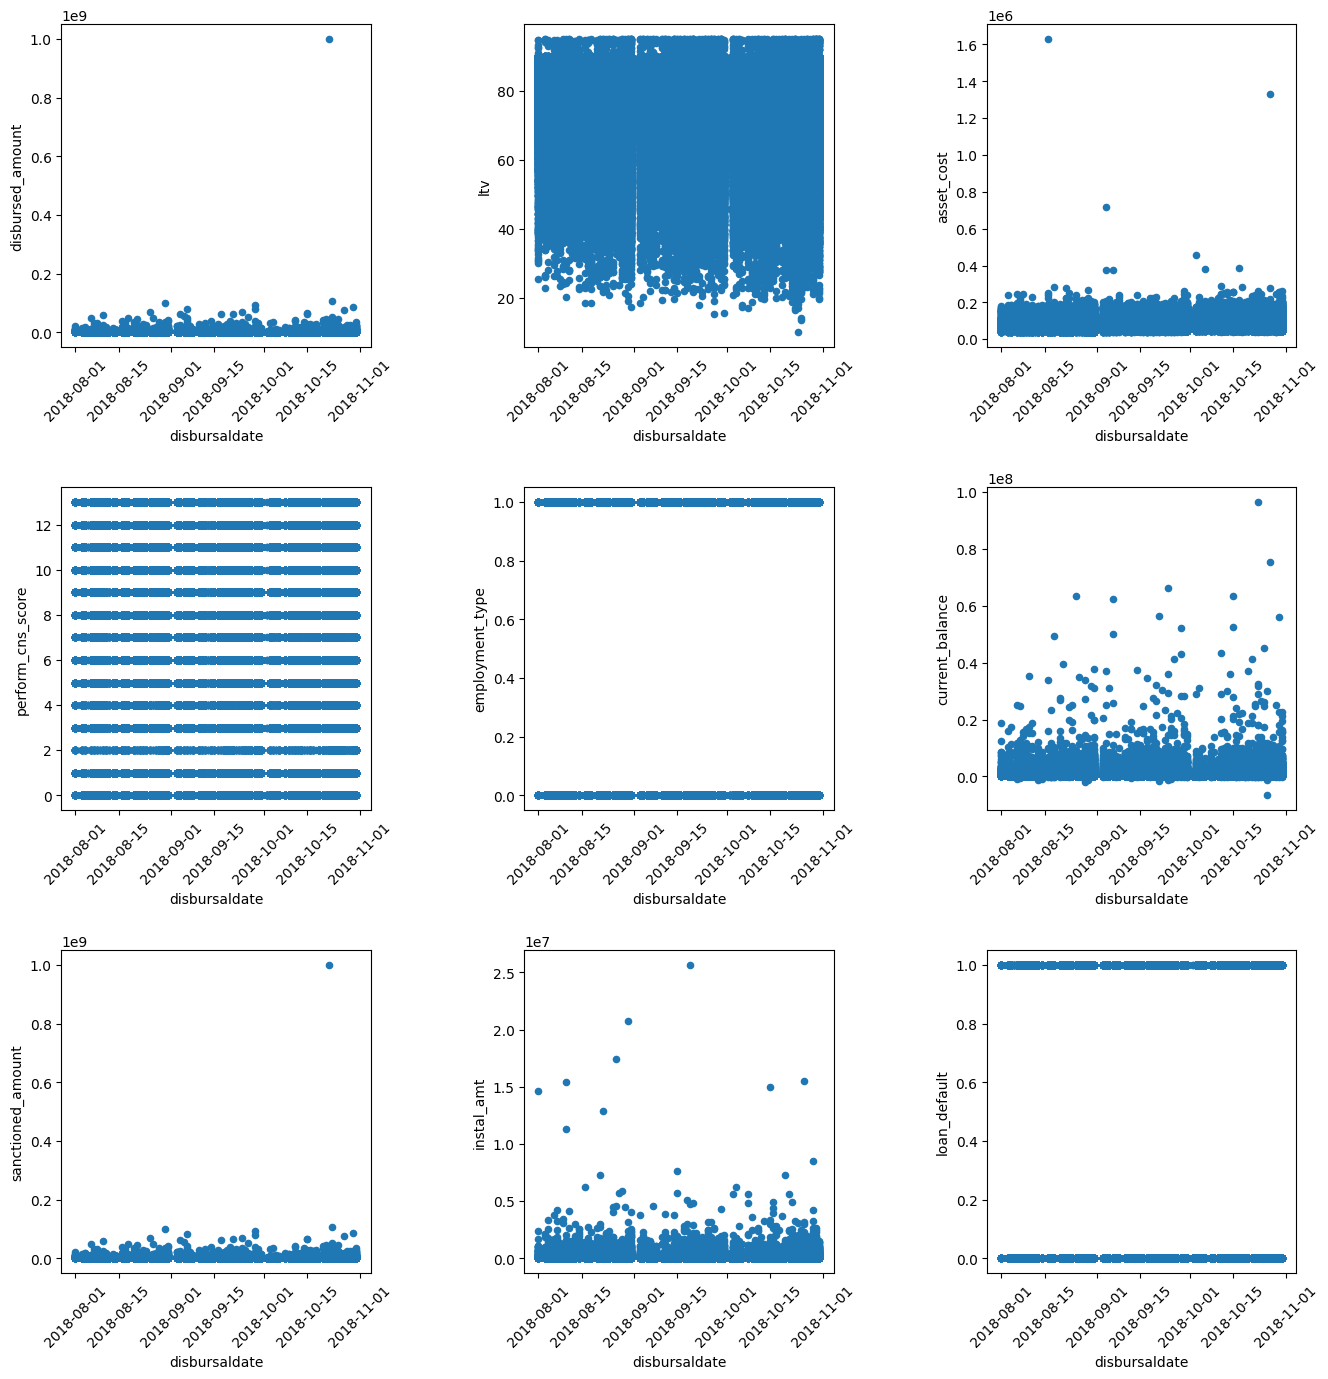

In [160]:
def transform_disb(string):
  date = datetime.strptime(string, '%d-%m-%y')
  return date

def transform_toord(date):
  return date.toordinal()

combine['disbursaldate'] = combine['disbursaldate'].apply(transform_disb)
interest_list = ['disbursed_amount', 'ltv', 'asset_cost', 'perform_cns_score', 'employment_type', 'current_balance', 'sanctioned_amount', 'instal_amt', 'loan_default']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
fig.tight_layout(pad=8.0)
for idx, feature in enumerate(interest_list):
  scatter_plot = combine.plot('disbursaldate', feature , subplots=True, kind='scatter', ax = axes[idx // 3, idx % 3])
  scatter_plot[0].set_xticks(scatter_plot[0].get_xticks())
  scatter_plot[0].tick_params(axis='x', rotation=45)


We can see that several outliers need to be removed to improve the results.

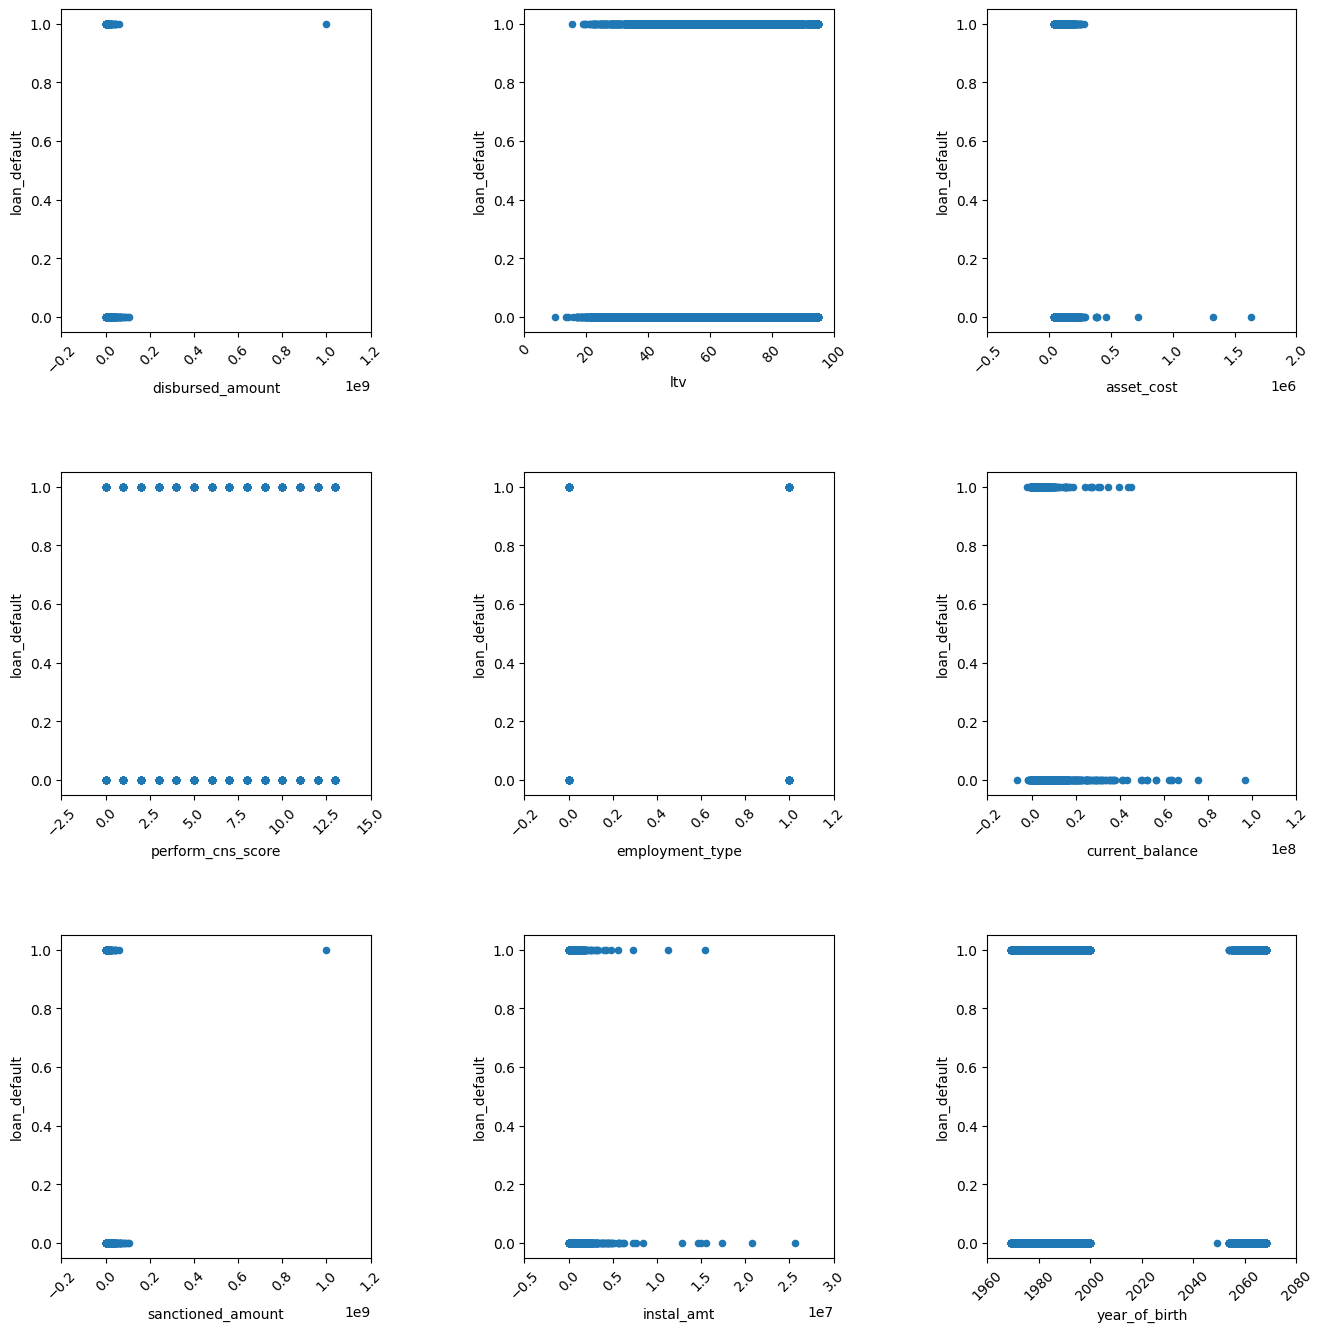

In [161]:
interest_list = ['disbursed_amount', 'ltv', 'asset_cost', 'perform_cns_score', 'employment_type', 'current_balance', 'sanctioned_amount', 'instal_amt', 'year_of_birth']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
fig.tight_layout(pad=8.0)
for idx, feature in enumerate(interest_list):
  scatter_plot = combine.plot(feature, 'loan_default', subplots=True, kind='scatter', ax = axes[idx // 3, idx % 3])
  scatter_plot[0].set_xticks(scatter_plot[0].get_xticks())
  scatter_plot[0].tick_params(axis='x', rotation=45)

However, we need to contunue our work with dates at the moment. This is time for columns average_acct_age and	credit_history_length.

In [162]:
def to_months(string):
  data = [int(elem.strip('yrsmon')) for elem in string.split(' ')]
  return data[0]*12 + data[1]
combine['disbursaldate'] = combine['disbursaldate'].apply(transform_toord)

combine['average_acct_age'] = combine['average_acct_age'].apply(to_months)
combine['credit_history_length'] = combine['credit_history_length'].apply(to_months)

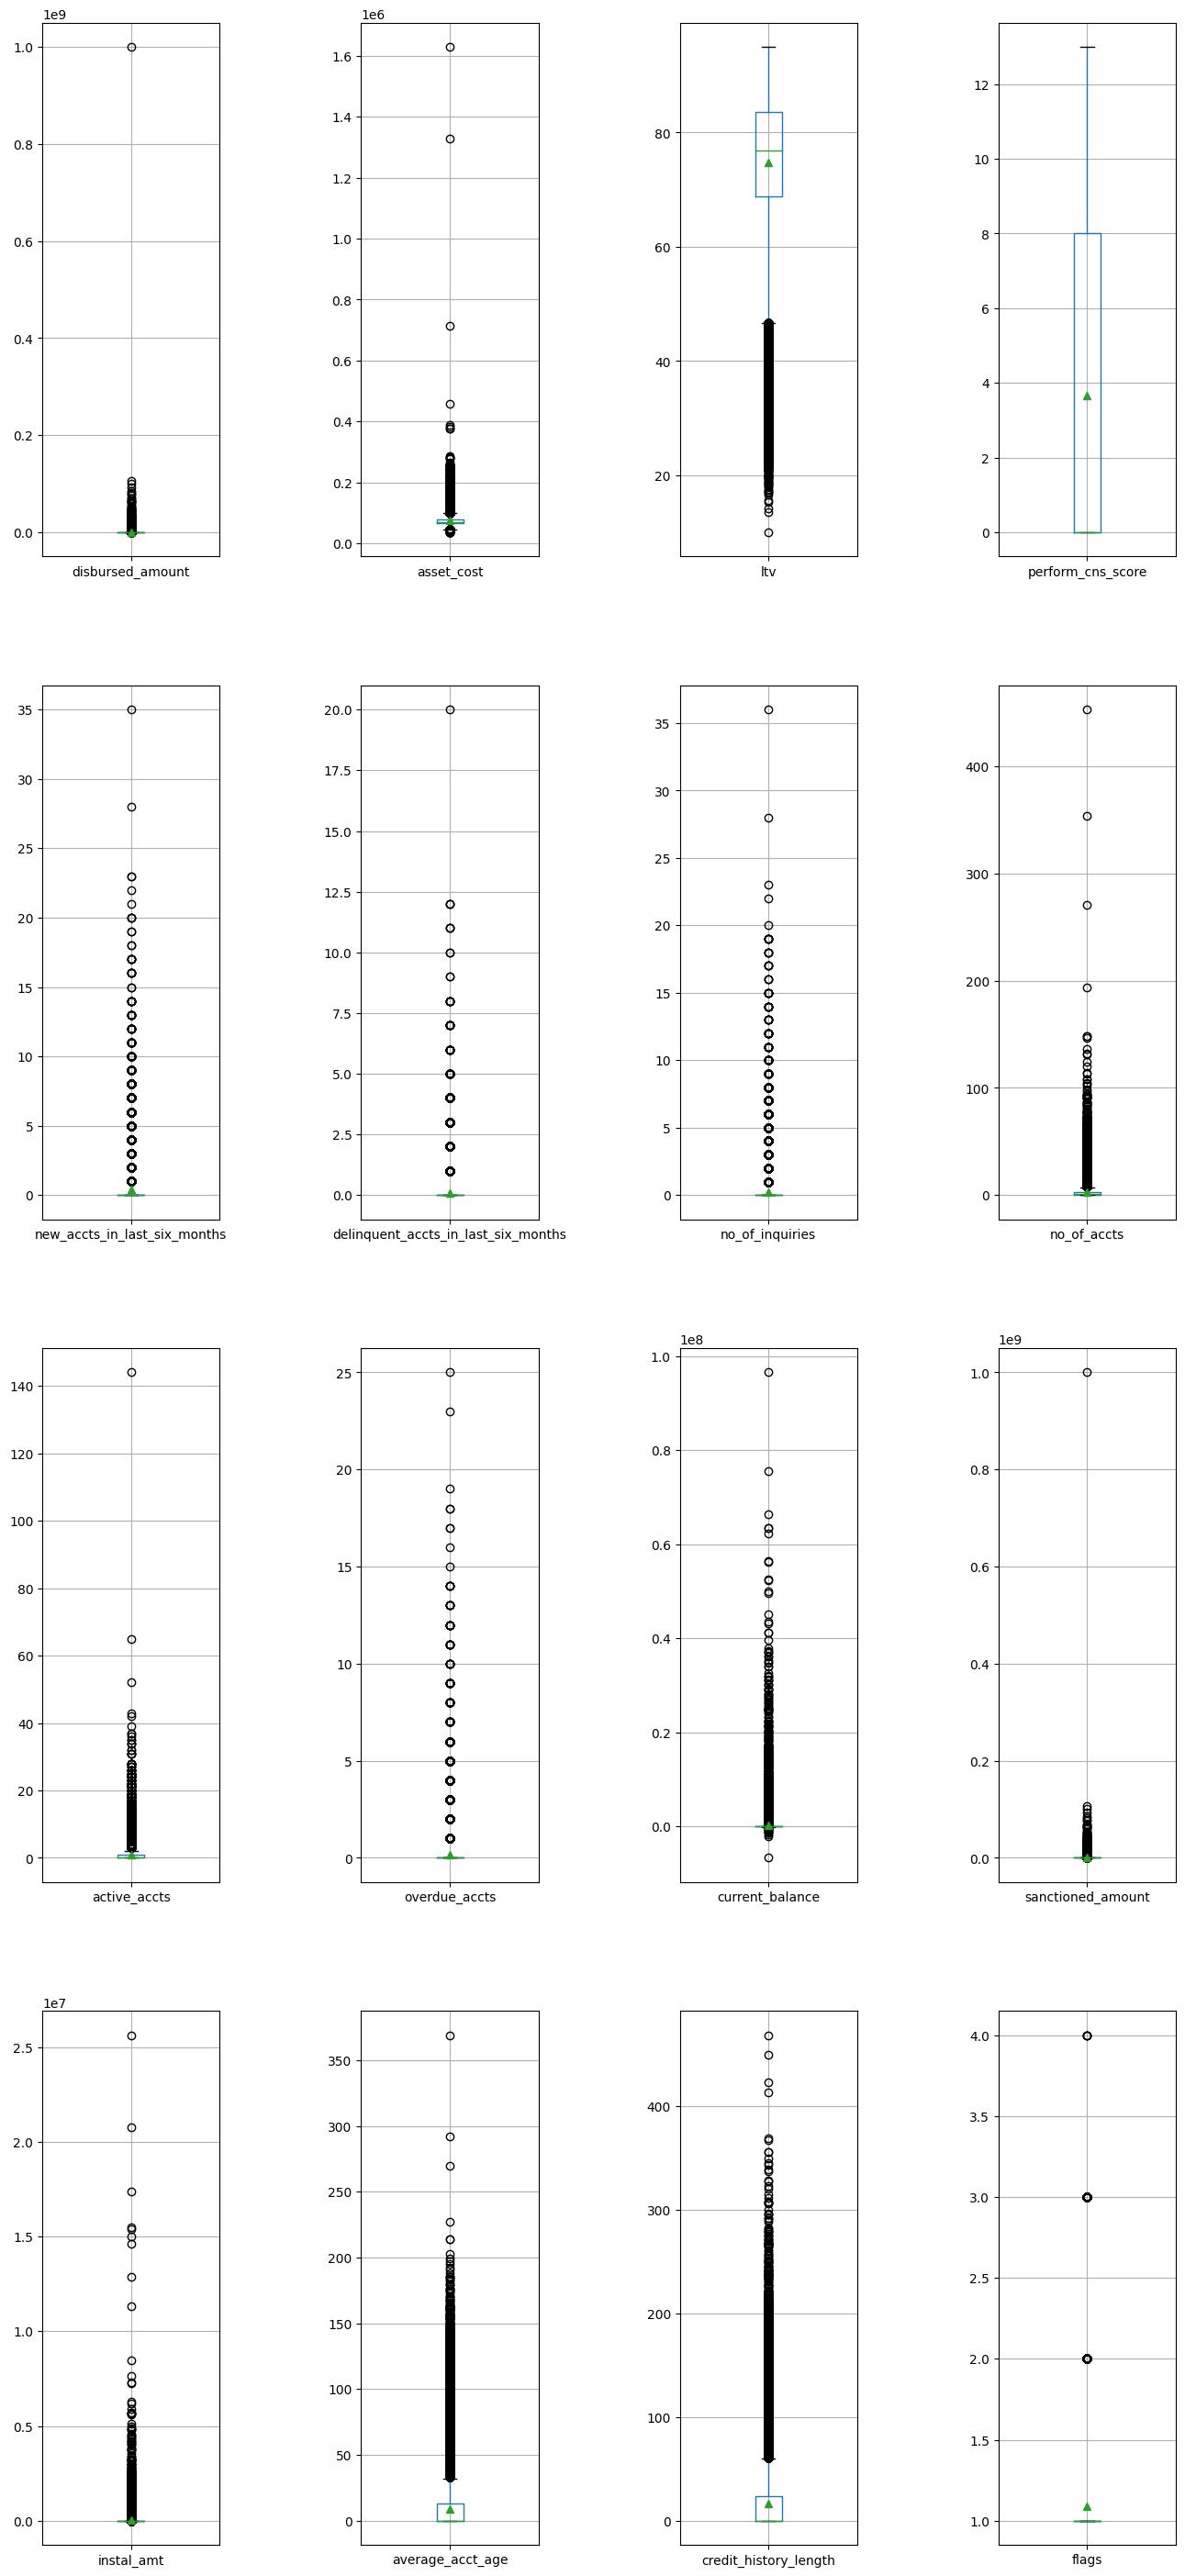

In [163]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 30))
fig.tight_layout(pad=8.0)
for idx, feature in enumerate(['disbursed_amount', 'asset_cost', 'ltv', 'perform_cns_score',
'new_accts_in_last_six_months', 'delinquent_accts_in_last_six_months', 'no_of_inquiries', 'no_of_accts',
'active_accts', 'overdue_accts', 'current_balance', 'sanctioned_amount', 'instal_amt', 'average_acct_age', 'credit_history_length', 'flags']):
  box_plot = combine.boxplot(feature, showmeans=True, ax = axes[idx // 4, idx % 4])

With these graphs, we can see some necessary boundaries for our data. Let's clean up our data from the outliers

In [164]:
combine['disbursed_amount'] = combine['disbursed_amount'][combine['disbursed_amount'] < 0.2 * 10**9].reset_index(drop=True)
combine['asset_cost'] = combine['asset_cost'][combine['asset_cost'] < 0.4 * 10**6].reset_index(drop=True)
combine['new_accts_in_last_six_months'] = combine['new_accts_in_last_six_months'][combine['new_accts_in_last_six_months'] < 25].reset_index(drop=True)
combine['delinquent_accts_in_last_six_months'] = combine['delinquent_accts_in_last_six_months'][combine['delinquent_accts_in_last_six_months'] < 12.5].reset_index(drop=True)
combine['no_of_inquiries'] = combine['no_of_inquiries'][combine['no_of_inquiries'] < 25].reset_index(drop=True)
combine['no_of_accts'] = combine['no_of_accts'][combine['no_of_accts'] < 175].reset_index(drop=True)
combine['active_accts'] = combine['active_accts'][combine['active_accts'] < 50].reset_index(drop=True)
combine['overdue_accts'] = combine['overdue_accts'][combine['overdue_accts'] < 20].reset_index(drop=True)
combine['current_balance'] = combine['current_balance'][combine['current_balance'] < 0.6 * 10**8].reset_index(drop=True)
combine['sanctioned_amount'] = combine['sanctioned_amount'][combine['sanctioned_amount'] < 0.2 * 10**9].reset_index(drop=True)
combine['instal_amt'] = combine['instal_amt'][combine['instal_amt'] < 1.75 * 10**7].reset_index(drop=True)
combine['average_acct_age'] = combine['average_acct_age'][combine['average_acct_age'] < 250].reset_index(drop=True)
combine['credit_history_length'] = combine['credit_history_length'][combine['credit_history_length'] < 400].reset_index(drop=True)

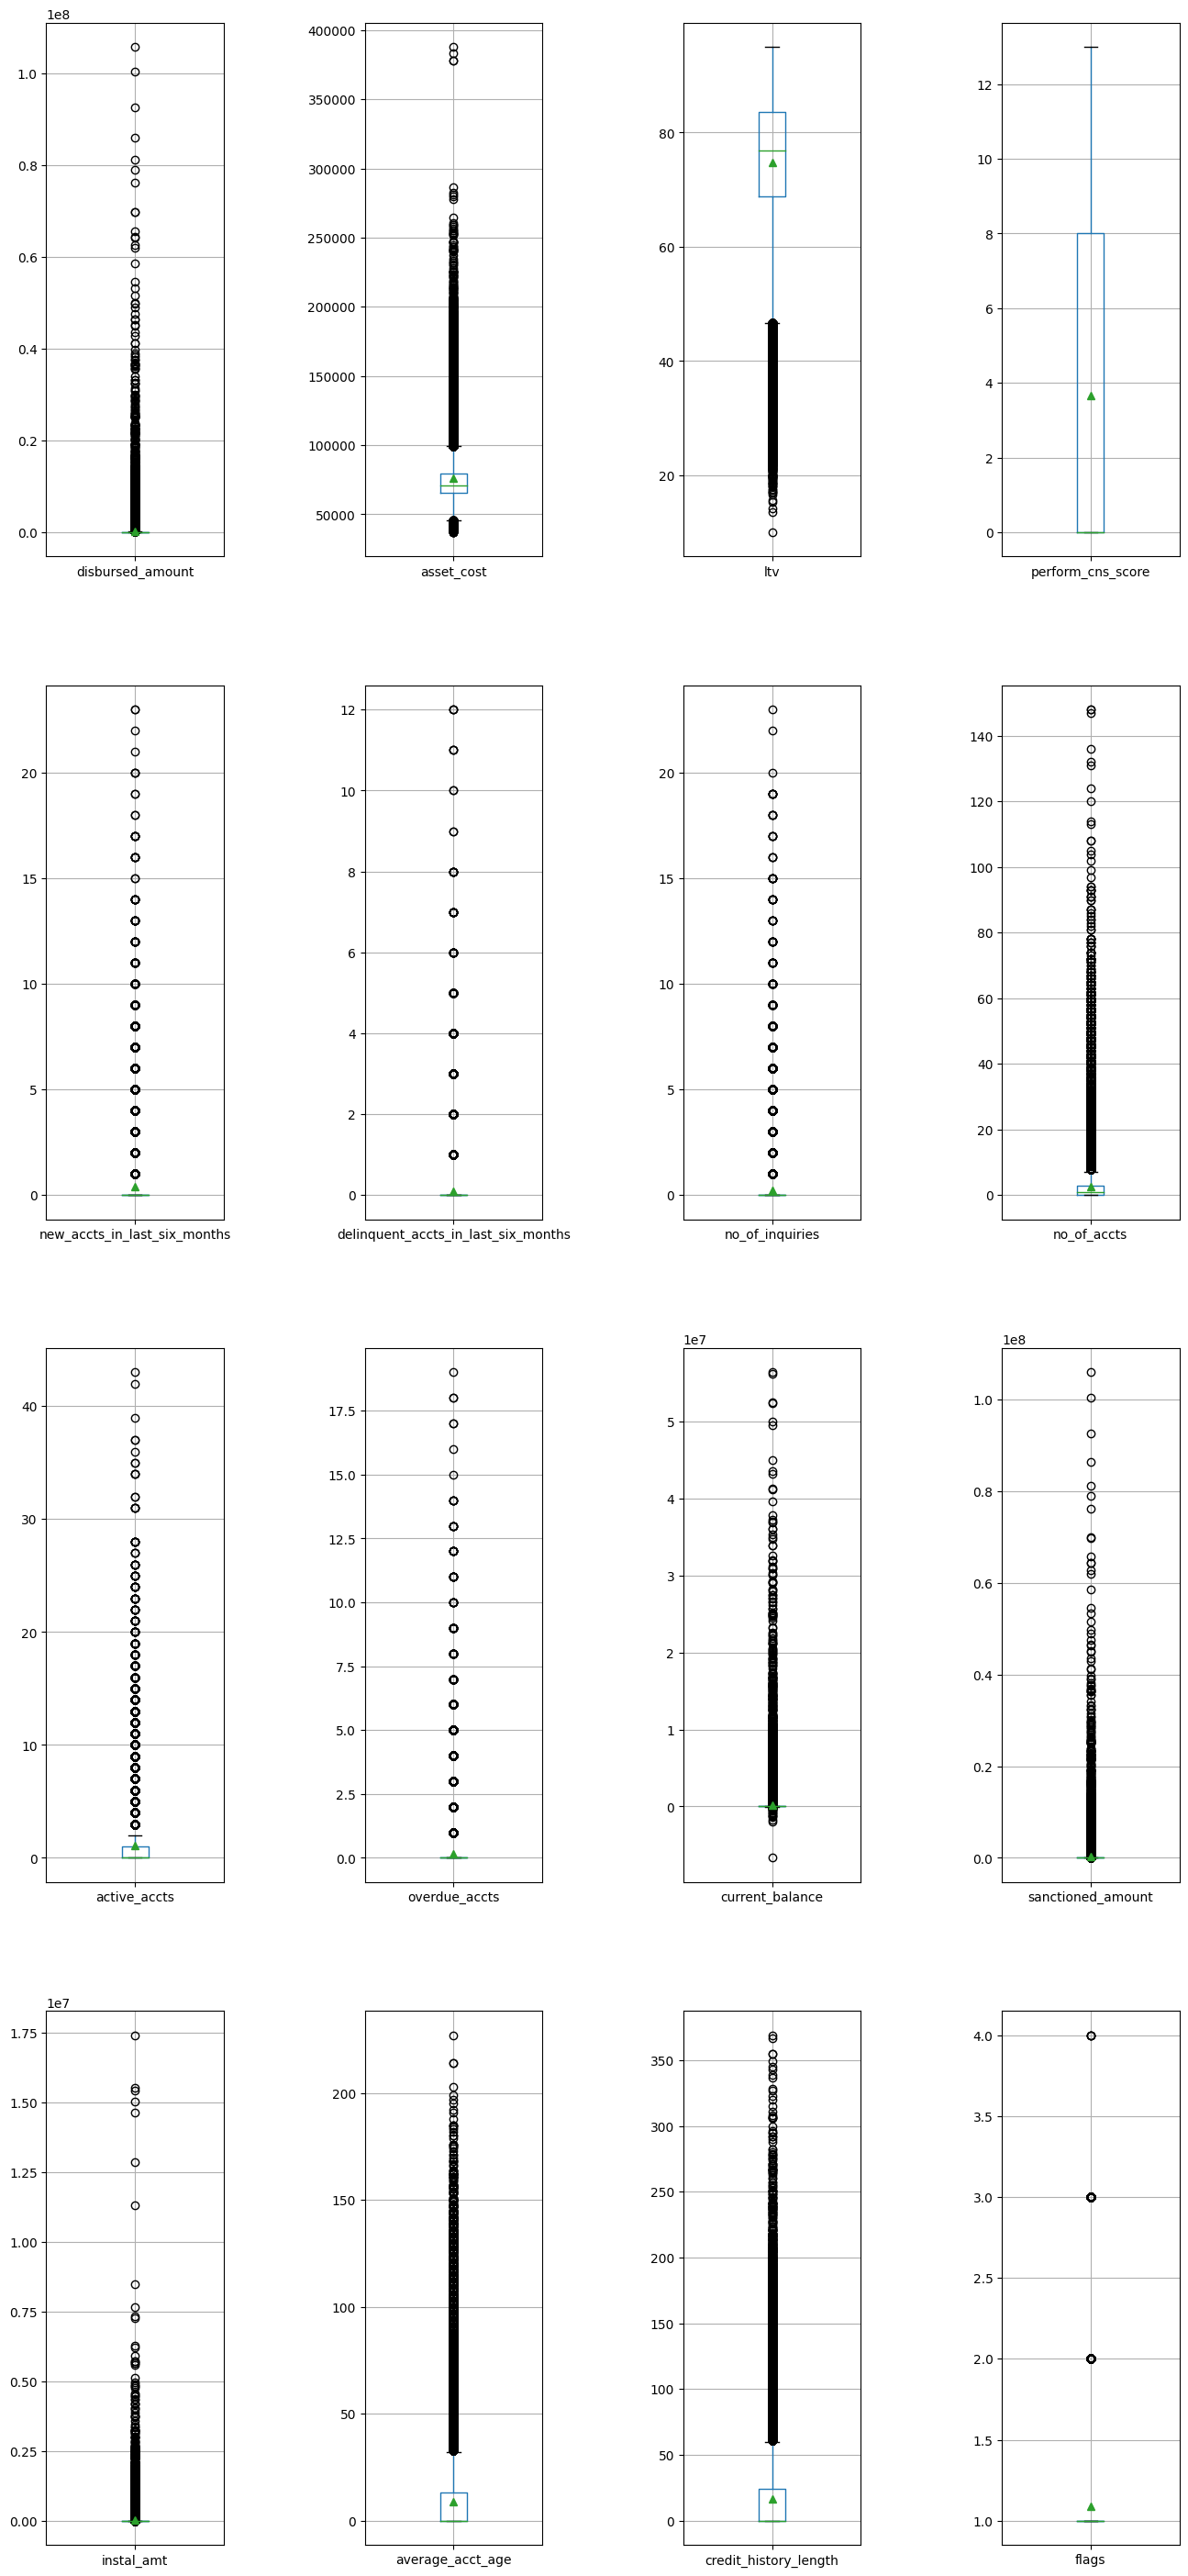

In [165]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 30))
fig.tight_layout(pad=8.0)
for idx, feature in enumerate(['disbursed_amount', 'asset_cost', 'ltv', 'perform_cns_score',
'new_accts_in_last_six_months', 'delinquent_accts_in_last_six_months', 'no_of_inquiries', 'no_of_accts',
'active_accts', 'overdue_accts', 'current_balance', 'sanctioned_amount', 'instal_amt', 'average_acct_age', 'credit_history_length', 'flags']):
  box_plot = combine.boxplot(feature, showmeans=True, ax = axes[idx // 4, idx % 4])

Now the data looks neater. However, we cannot use PCA and its visualization because of the huge size of the data. So we begin making baseline and our predictions.

Process the data_test using the previous actions

In [166]:
num_cols = data_test.select_dtypes(exclude='object')
num_cols.drop(['UniqueID', 'MobileNo_Avl_Flag'] , inplace=True, axis=1)
lst = ['branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Employee_code_ID']
num_cols.drop(lst, inplace=True, axis=1)
lst = list(num_cols.columns)

for col in num_cols.columns[lst.index('PRI.NO.OF.ACCTS'):lst.index('SEC.NO.OF.ACCTS')]:
  num_cols[f'{col.strip("PRI.").replace(".", "_").lower()}'] = num_cols[col] + num_cols[f'SEC.{col[4:]}']
  num_cols.drop([col, f'SEC.{col[4:]}'], inplace=True, axis=1)

num_cols['instal_amt'] = num_cols['PRIMARY.INSTAL.AMT'] + num_cols['SEC.INSTAL.AMT']
num_cols.drop(['PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT'], inplace=True, axis=1)

num_cols['flags'] = np.zeros(num_cols['Aadhar_flag'].shape)
for col in num_cols.columns[lst.index('Aadhar_flag'): lst.index('PERFORM_CNS.SCORE')]:
  num_cols['flags'] = num_cols['flags'] + num_cols[col]
  num_cols.drop(col, inplace=True, axis=1)

to_rename = {name: rename_col(name) for name in ['PERFORM_CNS.SCORE', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES']}
num_cols = num_cols.rename(columns=to_rename)

enconder = ce.binary.BinaryEncoder()

new_col = enconder.fit_transform(num_cols['State_ID'])
num_cols.drop('State_ID', inplace=True, axis=1)
num_cols = pd.concat([num_cols, new_col], axis=1)

cat_cols = data_train.select_dtypes(include='object')

to_rename = {name: rename_col(name) for name in cat_cols.columns}
cat_cols = cat_cols.rename(columns=to_rename)

bins = cat_cols['perform_cns_score_description']
labels = num_cols['perform_cns_score']
dct = {bin: [0, 10**6] for bin in set(bins)}

for i in range(len(labels)):
  if dct[bins[i]] == [0, 10**6]:
    dct[bins[i]] = [labels[i], labels[i]]
  else:
    if dct[bins[i]][0] > labels[i]:
      dct[bins[i]][0] = labels[i]
    elif dct[bins[i]][1] < labels[i]:
      dct[bins[i]][1] = labels[i]

dct['Entry'] = [0]
for key in dct.keys():
  if key[:2] == 'No':
    dct['Entry'].append(dct[key][0])

dct = {key: dct[key] for key in sorted(dct)}

for i in range(7):
  dct.popitem()

last_value = dct.pop('Entry')
dct.setdefault('Entry', last_value)

new_keys = {val: num for num, val in enumerate(reversed(dct))}
keys_cns = {tuple(dct[val]): new_keys[val] for val in new_keys}

def new_score_cns(num):
  for borders in keys_cns:
    if  borders[0] <= num <= borders[1]:
      return keys_cns[borders]
  return 0

num_cols['perform_cns_score'] = num_cols['perform_cns_score'].apply(new_score_cns)
cat_cols.drop('perform_cns_score_description', inplace=True, axis=1)
num_cols['perform_cns_score']

combine_test = pd.concat([num_cols, cat_cols], axis=1)

combine_test['employment_type'] = combine_test['employment_type'].apply(change_empl_type)
imputer.fit_transform(combine['employment_type'][:, np.newaxis])

combine_test['date_of_birth'] = combine_test['date_of_birth'].apply(transform_birth)
combine_test = combine_test.rename(columns={'date_of_birth': 'year_of_birth'})
combine_test['disbursaldate'] = combine_test['disbursaldate'].apply(transform_disb)
combine_test['disbursaldate'] = combine_test['disbursaldate'].apply(transform_toord)
combine_test['average_acct_age'] = combine_test['average_acct_age'].apply(to_months)
combine_test['credit_history_length'] = combine_test['credit_history_length'].apply(to_months)

combine_test = combine_test.dropna()

<ipython-input-166-94279189f373>:75: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  imputer.fit_transform(combine['employment_type'][:, np.newaxis])


Speaking of metrics, we see that classes differ, but not dramatically. This is not an example of finding 10 relevant sites out of 10,000 sites. So I think the AUC metric is appropriate for our conditions. Out task is very similar to  detection of malignant breast neoplasms: even values of target data take 1 as negative action (loan wasn't payed off) and 0 as positive action.

Speaking of model, I think KNN isn't suitable to our data (the algorithm is inefficient from memory). It would be better to choose logistic regression or decision tree for this task.

In [167]:
combine = combine.dropna()
needed_data = combine.copy()
needed_data.drop('loan_default', inplace=True, axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    needed_data,
    combine['loan_default'],
    random_state=2024,
    test_size=0.25
)

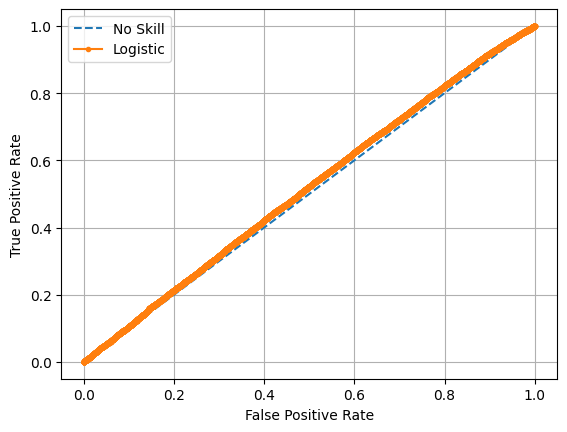

In [168]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

tree_clf = DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)

def plot_roc_auc(fpr, tpr, thresholds, title):
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.', label=title.split(' ')[0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.grid()
  plt.show()

y_pred = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc_auc(fpr, tpr, thresholds, title='Logistic regression')

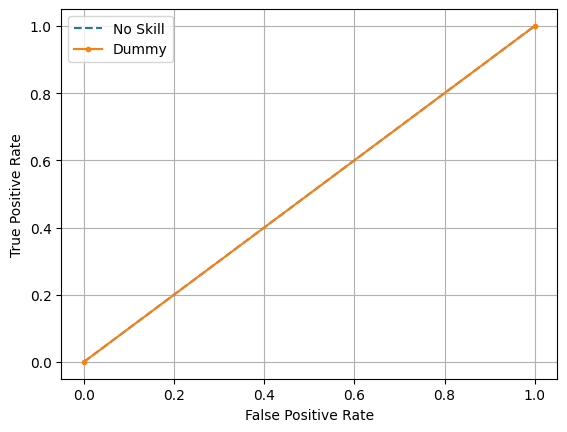

In [169]:
y_pred = dummy_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc_auc(fpr, tpr, thresholds, title='Dummy')

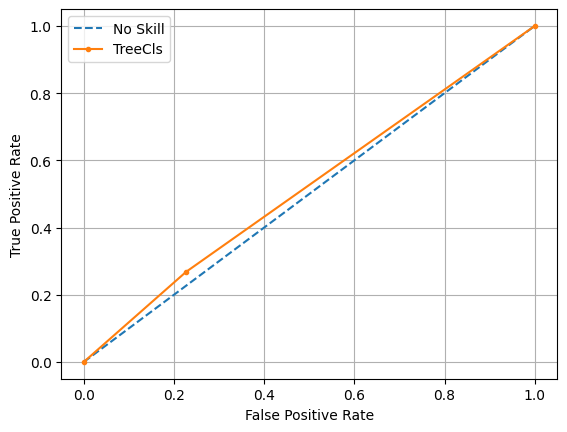

In [170]:
y_pred = tree_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc_auc(fpr, tpr, thresholds, title='TreeCls')

Using only AUC hasn't helped us to find the best model. Let's use cross-validation to do it.

In [172]:
def get_X_y(train):
  features = [
      'disbursed_amount', 'asset_cost', 'ltv', 'perform_cns_score',
       'new_accts_in_last_six_months', 'delinquent_accts_in_last_six_months',
       'no_of_inquiries', 'no_of_accts', 'active_accts',
       'overdue_accts', 'current_balance', 'sanctioned_amount', 'instal_amt',
       'flags', 'year_of_birth', 'employment_type',
       'disbursaldate', 'average_acct_age', 'credit_history_length'
  ]
  GROUPS = 'State_ID'
  target = 'loan_default'
  X = train[features]
  y = train[target]
  groups = train[GROUPS]
  return X, y, groups

In [173]:
sgk = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state = 2024)

X, y, groups = get_X_y(combine)

fold = 0
aucs = []
accs = []
rec = []

for train_idx, val_idx in sgk.split(X, y, groups):
  X_tr = X.loc[train_idx]
  y_tr = y.loc[train_idx]

  X_val = X.loc[val_idx]
  y_val = y.loc[val_idx]

  clf = DecisionTreeClassifier()
  clf.fit(X_tr, y_tr)
  pred = clf.predict(X_val)
  pred_prob = clf.predict_proba(X_val)[:, 1]
  acc_score = accuracy_score(y_val, pred)
  auc_score = roc_auc_score(y_val, pred_prob)
  rec_score = recall_score(y_val, pred)
  aucs.append(auc_score)
  accs.append(acc_score)
  rec.append(rec_score)
  print(f'Fold {fold}')
  fold += 1
  print(f'Accuracy on the validation set is {acc_score:0.4f}, AUC is {auc_score:0.4f} and recall is {rec_score:0.4f}')
print(f'Total for accuracy: {np.mean(aucs):0.4f}')
print(f'Total for AUC: {np.mean(accs):0.4f}')
print(f'Total for recall: {np.mean(rec):0.4f}')

Fold 0
Accuracy on the validation set is 0.6603, AUC is 0.5184 and recall is 0.2725
Fold 1
Accuracy on the validation set is 0.6239, AUC is 0.5113 and recall is 0.2203
Fold 2
Accuracy on the validation set is 0.6453, AUC is 0.5032 and recall is 0.2629
Fold 3
Accuracy on the validation set is 0.6665, AUC is 0.5057 and recall is 0.2498
Fold 4
Accuracy on the validation set is 0.6405, AUC is 0.5096 and recall is 0.2729
Fold 5
Accuracy on the validation set is 0.6719, AUC is 0.5215 and recall is 0.2840
Fold 6
Accuracy on the validation set is 0.6692, AUC is 0.5155 and recall is 0.2516
Fold 7
Accuracy on the validation set is 0.6534, AUC is 0.5163 and recall is 0.2784
Fold 8
Accuracy on the validation set is 0.6608, AUC is 0.5142 and recall is 0.2639
Fold 9
Accuracy on the validation set is 0.6576, AUC is 0.5186 and recall is 0.2590
Total for accuracy: 0.5134
Total for AUC: 0.6549
Total for recall: 0.2615


In [174]:
fold = 0
aucs = []
accs = []
rec = []

for train_idx, val_idx in sgk.split(X, y, groups):
  X_tr = X.loc[train_idx]
  y_tr = y.loc[train_idx]

  X_val = X.loc[val_idx]
  y_val = y.loc[val_idx]

  clf = LogisticRegression()
  clf.fit(X_tr, y_tr)
  pred = clf.predict(X_val)
  pred_prob = clf.predict_proba(X_val)[:, 1]
  acc_score = accuracy_score(y_val, pred)
  auc_score = roc_auc_score(y_val, pred_prob)
  rec_score = recall_score(y_val, pred)
  aucs.append(auc_score)
  accs.append(acc_score)
  rec.append(rec_score)
  print(f'Fold {fold}')
  fold += 1
  print(f'Accuracy on the validation set is {acc_score:0.4f}, AUC is {auc_score:0.4f} and recall is {rec_score:0.4f}')
print(f'Total for accuracy: {np.mean(aucs):0.4f}')
print(f'Total for AUC: {np.mean(accs):0.4f}')
print(f'Total for recall: {np.mean(rec):0.4f}')

Fold 0
Accuracy on the validation set is 0.7885, AUC is 0.5168 and recall is 0.0000
Fold 1
Accuracy on the validation set is 0.6934, AUC is 0.5017 and recall is 0.0000
Fold 2
Accuracy on the validation set is 0.7957, AUC is 0.5126 and recall is 0.0000
Fold 3
Accuracy on the validation set is 0.8140, AUC is 0.5104 and recall is 0.0000
Fold 4
Accuracy on the validation set is 0.7766, AUC is 0.5081 and recall is 0.0000
Fold 5
Accuracy on the validation set is 0.8164, AUC is 0.4940 and recall is 0.0000
Fold 6
Accuracy on the validation set is 0.7913, AUC is 0.5150 and recall is 0.0000
Fold 7
Accuracy on the validation set is 0.7881, AUC is 0.5133 and recall is 0.0000
Fold 8
Accuracy on the validation set is 0.7930, AUC is 0.5316 and recall is 0.0000
Fold 9
Accuracy on the validation set is 0.7678, AUC is 0.5068 and recall is 0.0000
Total for accuracy: 0.5110
Total for AUC: 0.7825
Total for recall: 0.0000


In [175]:
fold = 0
aucs = []
accs = []
rec = []

for train_idx, val_idx in sgk.split(X, y, groups):
  X_tr = X.loc[train_idx]
  y_tr = y.loc[train_idx]

  X_val = X.loc[val_idx]
  y_val = y.loc[val_idx]

  clf = DummyClassifier(strategy="most_frequent")
  clf.fit(X_tr, y_tr)
  pred = clf.predict(X_val)
  pred_prob = clf.predict_proba(X_val)[:, 1]
  acc_score = accuracy_score(y_val, pred)
  auc_score = roc_auc_score(y_val, pred_prob)
  rec_score = recall_score(y_val, pred)
  aucs.append(auc_score)
  accs.append(acc_score)
  rec.append(rec_score)
  print(f'Fold {fold}')
  fold += 1
  print(f'Accuracy on the validation set is {acc_score:0.4f}, AUC is {auc_score:0.4f} and recall is {rec_score:0.4f}')
print(f'Total for accuracy: {np.mean(aucs):0.4f}')
print(f'Total for AUC: {np.mean(accs):0.4f}')
print(f'Total for recall: {np.mean(rec):0.4f}')

Fold 0
Accuracy on the validation set is 0.7885, AUC is 0.5000 and recall is 0.0000
Fold 1
Accuracy on the validation set is 0.6934, AUC is 0.5000 and recall is 0.0000
Fold 2
Accuracy on the validation set is 0.7957, AUC is 0.5000 and recall is 0.0000
Fold 3
Accuracy on the validation set is 0.8140, AUC is 0.5000 and recall is 0.0000
Fold 4
Accuracy on the validation set is 0.7766, AUC is 0.5000 and recall is 0.0000
Fold 5
Accuracy on the validation set is 0.8164, AUC is 0.5000 and recall is 0.0000
Fold 6
Accuracy on the validation set is 0.7913, AUC is 0.5000 and recall is 0.0000
Fold 7
Accuracy on the validation set is 0.7881, AUC is 0.5000 and recall is 0.0000
Fold 8
Accuracy on the validation set is 0.7930, AUC is 0.5000 and recall is 0.0000
Fold 9
Accuracy on the validation set is 0.7678, AUC is 0.5000 and recall is 0.0000
Total for accuracy: 0.5000
Total for AUC: 0.7825
Total for recall: 0.0000


After this part we have clarified that Decision Tree is the best amoung the all.

Finally, let us try to predict the loan_default value for data_train and analyze it using Logistic regression

<ipython-input-176-22a99477f1e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combine.drop('loan_default', inplace=True, axis=1)


(array([135295.,  97853.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

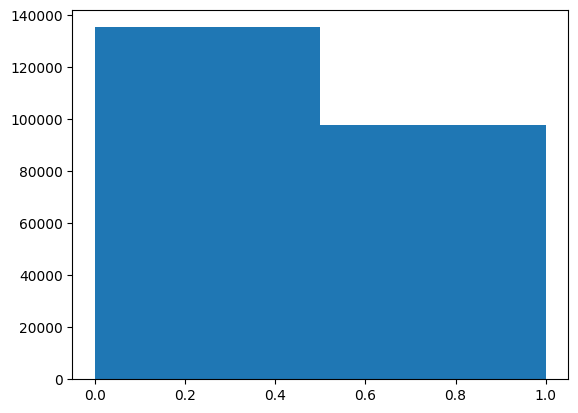

In [176]:
y_train = combine['loan_default']
combine.drop('loan_default', inplace=True, axis=1)
X_train = combine
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(combine_test)[:, 1]
combine_test['loan_default'] = y_pred

plt.hist(combine['employment_type'], bins=2)